In [35]:
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
metadata_df = pd.read_csv("~/mrc/project/sita_eisa/processed/092220_eisametadata.tsv", sep="\t")

metadata_df.head()

,GSE,Study,Organism,Cell/Tissue type,Treatment(s),Time (hr),Genotype(s),Disease model,N,Runs,...,Comparison,p_intron,EISA_nsig,EISA_Up:Down,DESeq_nsig,DESeq_Up:Down,SITA,Remarks,Other seq,Colour
0,GSE103719,Inflammation,Homo sapiens,HEK293T cells,DMSO vs. THAP,2,None,None,4,1,...,DMSO vs. THAP,0.05265,485.0,0.061269,971.0,1.568783,TRUE,Positive control with Barbara's result (human).,"TED-seq, Ribo-seq, PRO-seq",B
1,GSE105155,Inflammation,Mus musculus,BV2 microglia,Control vs. LPS,3,TET2 (siRNA KD) vs. WT,None,2-3,1,...,siScr_Ctrl vs. siScr_LPS,0.15270,311.0,0.352174,2108.0,1.445476,TRUE?,NaN,None,B
2,GSE105155,Inflammation,Mus musculus,BV2 microglia,Control vs. LPS,3,TET2 (siRNA KD) vs. WT,None,2-3,1,...,siTet2_Ctrl vs. siTet2_LPS,0.13360,110.0,0.692308,1644.0,1.355301,FALSE,siTet2 LPS rep1 missing. Less SITA in siTet2 s...,None,B
3,GSE106789,Inflammation,Mus musculus,Granulocyte-monocyte progenitor cells,PBS vs. LPS injection (intravenous),6,Nlrp3 (-/-) Ldlr (-/-),None,3-4,1,...,batch2_chow_PBS vs. batch2_chow_LPS,0.10880,158.0,0.362069,1814.0,1.402649,TRUE,No WT control.,None,B
4,GSE108770,Inflammation,Mus musculus,N9 microglia,Normal vs. LPS,3,None,None,3-5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Normal is SINGLE, LPS is PAIRED - cannot proce...",ChIP-seq,R


In [8]:
# General GSE stats
total_gse = len(metadata_df['GSE'].unique())
blue_gse = len(metadata_df.loc[metadata_df['Colour'] == 'B']['GSE'].unique())
rw_gse = len(metadata_df.loc[metadata_df['Colour'].isin(['R', 'W'])]['GSE'].unique())
yellow_gse = len(metadata_df.loc[metadata_df['Colour'] == 'Y']['GSE'].unique())

print(f"Total GSEs: {total_gse}")
print(f"Completed GSEs: {blue_gse}")
print(f"GSEs in progress: {yellow_gse}")
print(f"Unprocessed GSEs: {rw_gse}")


Total GSEs: 86
Completed GSEs: 58
GSEs in progress: 11
Unprocessed GSEs: 17


In [25]:
# Comparison stats for each dataset
datasets = ['Inflammation', 'ND']
for dataset in datasets:
    complete_comp = metadata_df.loc[(metadata_df['Colour'] == 'B') & (metadata_df['Study'] == dataset)]
    total_gse = len(complete_comp['GSE'].unique())
    total_comp = len(complete_comp)

    print(f"Total GSEs for {dataset}: {total_gse}")
    print(f"Total comparisons for {dataset}: {total_comp}\n")

    sita_values = complete_comp['SITA'].value_counts(dropna=False).to_dict()

    for sita, value in sita_values.items():
        print(f"{sita}: {round((value / total_comp) * 100, 2)}%")

    print("")

Total GSEs for Inflammation: 32
Total comparisons for Inflammation: 48

TRUE: 29.17%
FALSE: 27.08%
FALSE*: 16.67%
TRUE?: 10.42%
nan: 10.42%
FALSE?: 4.17%
FALSE*?: 2.08%

Total GSEs for ND: 26
Total comparisons for ND: 56

nan: 39.29%
FALSE*: 16.07%
TRUE?: 16.07%
TRUE: 14.29%
FALSE: 8.93%
FALSE?: 3.57%
FALSE*?: 1.79%



Total NA comparisons: 27


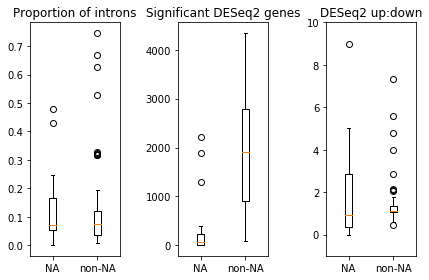

In [71]:
# Analysis of NA comparisons
na_comps = metadata_df[metadata_df['Colour'] == 'B'].loc[metadata_df['SITA'].isna()]
nonna_comps = metadata_df[metadata_df['Colour'] == 'B'].loc[~(metadata_df['SITA'].isna())]

print(f"Total NA comparisons: {len(na_comps)}")

fig, axs = plt.subplots(1, 3)

axs[0].boxplot([na_comps['p_intron'], nonna_comps['p_intron']], labels=['NA', 'non-NA'])
axs[0].set_title("Proportion of introns")

axs[1].boxplot([na_comps['DESeq_nsig'], nonna_comps['DESeq_nsig']], labels=['NA', 'non-NA'])
axs[1].set_title("Significant DESeq2 genes")

axs[2].boxplot([na_comps['DESeq_Up:Down'].dropna(), nonna_comps['DESeq_Up:Down']], labels=['NA', 'non-NA'])
axs[2].set_ylim([-1, 10])
axs[2].set_title("DESeq2 up:down")

fig.tight_layout()